## PyTorch Datasets and DataLoaders

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

In [1]:
!pip install torch torchvision
#!pip install transform
import torch
import torchvision
import torchvision.transforms as transforms

# Define data transformations for training data
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # 随机水平翻转图像
    transforms.RandomCrop(32, padding=4),  # 随机裁剪图像，并在周围填充0
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize
])

# Define data transformations for test data
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize
])

# Load the CIFAR10 dataset
train_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train
)

test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test
)

# Create DataLoaders for train and test datasets
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=64, shuffle=True, num_workers=2
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=64, shuffle=False, num_workers=2
)

print("Num training examples: {}".format(len(train_dataset)))
print("Num test examples: {}".format(len(test_dataset)))


# List of class labels
classes = [
    'plane', 'car', 'bird', 'cat',
    'deer', 'dog', 'frog', 'horse', 'ship', 'truck'
]

Files already downloaded and verified
Files already downloaded and verified
Num training examples: 50000
Num test examples: 10000


In [2]:
# Fetch one batch of data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Inspect the shapes and value ranges of images (X) and labels (Y)
images_shape = images.shape
images_dtype = images.dtype
images_min = images.min().item()
images_max = images.max().item()

labels_shape = labels.shape
labels_dtype = labels.dtype

images_shape, images_dtype, images_min, images_max, labels_shape, labels_dtype

(torch.Size([64, 3, 32, 32]),
 torch.float32,
 -1.0,
 1.0,
 torch.Size([64]),
 torch.int64)

## Visualizing Examples from the CIFAR10 Dataset

In [3]:
%pip install matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Function to unnormalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Display the images in a grid along with their labels
imshow(torchvision.utils.make_grid(images[:16]))
print(" -- ".join(f"{classes[labels[j]]}" for j in range(8)))
print(" -- ".join(f"{classes[labels[j]]}" for j in range(8,16)))

Note: you may need to restart the kernel to use updated packages.


: 

## Training on the GPU and Evaluating Performance
Calculate train and test accuracy

In [2]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Set the random seed for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Define the neural network
class TwoLayerNet(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(TwoLayerNet, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, D_out)
        self.device = 'cpu'

        # Initialize weights of self.linear with a small random number from a normal distribution
        #nn.init.normal_(self.linear1.weight, mean=0.0, std=0.01)
        #nn.init.normal_(self.linear2.weight, mean=0.0, std=0.01)
        nn.init.kaiming_uniform_(self.linear1.weight, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_uniform_(self.linear2.weight, mode='fan_in', nonlinearity='relu')

    def forward(self, x):
        x = x.view(-1, 3*32*32)  # 將x展平以匹配全連接層的期望輸入形狀
        h_relu = self.linear1(x).clamp(min=0)
        y_pred = self.linear2(h_relu)
        return y_pred
    
    def to(self, device):
        self.device = device  # Set the device attribute
        super().to(device)    # Call the parent class' to method    
    
    def evaluate_model(self, test_loader, criterion):
        # let's evaluate its performance on the test dataset.
        self.eval()
        # Test the neural network
        correct = 0
        total = 0
        test_loss = 0.0

        # Disable gradient calculation
        with torch.no_grad():
            for inputs, labels in test_loader:
                #print(inputs.size(), labels.size())

                # Move the inputs and labels to the GPU if available
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)

                # Forward pass
                outputs = self(inputs)

                # Calculate test loss
                loss = criterion(outputs, labels)
                test_loss += loss.item() * inputs.size(0)  # 将损失累加，考虑到每个批次的大小
                
                # Get the predicted class
                _, predicted = torch.max(outputs.data, 1)

                # Update the total number of samples and correct predictions
                total += labels.size(0) 
                correct += (predicted == labels).sum().item()

        # 计算平均测试损失
        avg_test_loss = test_loss / len(test_loader.dataset)
        # Calculate the accuracy
        test_accuracy = 100 * correct / total
        return avg_test_loss, test_accuracy

In [3]:
def reset_and_initialize():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)
    net = TwoLayerNet(3*32*32, 1000, 10)
    net.to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)#weight_decay=L2λ 添加一个与权重大小相关的L2项来抑制过拟合，影响梯度更新。
    return net, optimizer, device

### Epoch Bound(EB)

In [14]:
# Example usage
net, optimizer, device = reset_and_initialize()
criterion = nn.CrossEntropyLoss() #分類任務的損失函數

trn_loss_eb = []
trn_acc_eb = []
val_loss_eb = []
val_acc_eb = []  

# Train the neural network
max_epochs = 10

for epoch_eb in range(max_epochs):
    # Set the model to training mode
    net.train()  
    running_loss = 0.0
    train_correct = 0
    train_total = 0

    for i, (inputs, labels) in enumerate(train_loader, 0): #每個epoch内，模型處理782個mini-batch=64張圖，共50000張圖。
        # Move the inputs and labels to the GPU if available
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = net(inputs)

        # Compute the loss
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Update the running loss
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    # 訓練損失: 782個mini-batch loss的平均值
    avg_train_loss = running_loss / (i + 1)
    train_accuracy = 100 * train_correct / train_total
    trn_loss_eb.append(avg_train_loss)
    trn_acc_eb.append(train_accuracy)

    # Evaluate on test data after each epoch
    avg_test_loss, test_accuracy = TwoLayerNet.evaluate_model(net, test_loader, criterion)
    print(f"Epoch: {epoch_eb + 1}, TrainLoss: {avg_train_loss:.4f}, TrainAccuracy: {train_accuracy:.2f}%, TestLoss: {avg_test_loss:.4f}, TestAccuracy: {test_accuracy:.2f}%")
    val_loss_eb.append(avg_test_loss)
    val_acc_eb.append(test_accuracy)

Using device: cpu
Epoch: 1, TrainLoss: 1.9404, TrainAccuracy: 34.06%, TestLoss: 2.2566, TestAccuracy: 36.30%
Epoch: 2, TrainLoss: 1.7195, TrainAccuracy: 38.88%, TestLoss: 1.8106, TestAccuracy: 39.91%
Epoch: 3, TrainLoss: 1.6711, TrainAccuracy: 40.31%, TestLoss: 1.8144, TestAccuracy: 41.10%
Epoch: 4, TrainLoss: 1.6567, TrainAccuracy: 40.90%, TestLoss: 1.9351, TestAccuracy: 38.89%
Epoch: 5, TrainLoss: 1.6499, TrainAccuracy: 41.19%, TestLoss: 2.0084, TestAccuracy: 38.01%
Epoch: 6, TrainLoss: 1.6371, TrainAccuracy: 41.69%, TestLoss: 1.8806, TestAccuracy: 40.70%
Epoch: 7, TrainLoss: 1.6296, TrainAccuracy: 41.98%, TestLoss: 1.8653, TestAccuracy: 38.85%
Epoch: 8, TrainLoss: 1.6257, TrainAccuracy: 42.19%, TestLoss: 1.9214, TestAccuracy: 39.64%
Epoch: 9, TrainLoss: 1.6176, TrainAccuracy: 42.29%, TestLoss: 1.9017, TestAccuracy: 40.51%
Epoch: 10, TrainLoss: 1.6174, TrainAccuracy: 42.37%, TestLoss: 1.7914, TestAccuracy: 42.55%


### Learning Goal(LG)

In [15]:
# Example usage
net, optimizer, device = reset_and_initialize()
criterion = nn.CrossEntropyLoss() #分類任務的損失函數

trn_loss_lg = []
trn_acc_lg = []
val_loss_lg = []
val_acc_lg = []

epsilon = 1.6
epoch_lg = 0

while True:
    # Set the model to training mode
    net.train()  
    running_loss = 0.0
    train_correct = 0
    train_total = 0

    for i, (inputs, labels) in enumerate(train_loader, 0): #每個epoch内，模型處理782個mini-batch=64張圖，共50000張圖。
        # Move the inputs and labels to the GPU if available
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = net(inputs)

        # Compute the loss
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Update the running loss
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    # 訓練損失: 782個mini-batch loss的平均值
    avg_train_loss = running_loss / (i + 1)
    train_accuracy = 100 * train_correct / train_total
    trn_loss_lg.append(avg_train_loss)
    trn_acc_lg.append(train_accuracy)

    # Evaluate on test data after each epoch
    avg_test_loss, test_accuracy = TwoLayerNet.evaluate_model(net, test_loader, criterion)
    print(f"Epoch: {epoch_lg+1}, TrainLoss: {avg_train_loss:.4f}, TrainAccuracy: {train_accuracy:.2f}%, TestLoss: {avg_test_loss:.4f}, TestAccuracy: {test_accuracy:.2f}%")
    val_loss_lg.append(avg_test_loss)
    val_acc_lg.append(test_accuracy)
    
    if avg_train_loss < epsilon:
        print(f"Stopping training in the epoch {epoch_lg+1} as the average train loss {avg_train_loss:.4f} is less than epsilon {epsilon}, acceptable 2LNN.")
        break
    epoch_lg += 1

Using device: cpu
Epoch: 1, TrainLoss: 1.9448, TrainAccuracy: 33.51%, TestLoss: 2.4100, TestAccuracy: 35.24%
Epoch: 2, TrainLoss: 1.7156, TrainAccuracy: 39.30%, TestLoss: 1.8786, TestAccuracy: 38.38%
Epoch: 3, TrainLoss: 1.6748, TrainAccuracy: 39.98%, TestLoss: 1.8491, TestAccuracy: 40.63%
Epoch: 4, TrainLoss: 1.6597, TrainAccuracy: 40.90%, TestLoss: 1.7286, TestAccuracy: 41.25%
Epoch: 5, TrainLoss: 1.6513, TrainAccuracy: 41.32%, TestLoss: 1.9521, TestAccuracy: 37.82%
Epoch: 6, TrainLoss: 1.6431, TrainAccuracy: 41.82%, TestLoss: 1.7475, TestAccuracy: 40.61%
Epoch: 7, TrainLoss: 1.6301, TrainAccuracy: 41.66%, TestLoss: 1.9061, TestAccuracy: 38.77%
Epoch: 8, TrainLoss: 1.6250, TrainAccuracy: 42.25%, TestLoss: 1.8637, TestAccuracy: 40.69%
Epoch: 9, TrainLoss: 1.6263, TrainAccuracy: 41.88%, TestLoss: 1.8138, TestAccuracy: 41.20%
Epoch: 10, TrainLoss: 1.6235, TrainAccuracy: 42.31%, TestLoss: 1.9024, TestAccuracy: 39.39%
Epoch: 11, TrainLoss: 1.6195, TrainAccuracy: 42.33%, TestLoss: 1.8763, 

### EB or LG

In [16]:
# Example usage
net, optimizer, device = reset_and_initialize()
criterion = nn.CrossEntropyLoss() #分類任務的損失函數

trn_loss_eb_lg = []
trn_acc_eb_lg = []
val_loss_eb_lg = []
val_acc_eb_lg = []  

# Train the neural network
epsilon = 1.6
max_epochs = 10
epoch_eb_lg = 0

#scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=0)
while True:
    # Set the model to training mode
    net.train()  
    running_loss = 0.0
    train_correct = 0
    train_total = 0

    for i, (inputs, labels) in enumerate(train_loader, 0): #每個epoch内，模型處理782個mini-batch=64張圖，共50000張圖。
        # Move the inputs and labels to the GPU if available
        inputs = inputs.to(device)
        labels = labels.to(device)


        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = net(inputs)

        # Compute the loss
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Update the running loss
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    # 訓練損失: 782個mini-batch loss的平均值
    avg_train_loss = running_loss / (i + 1)
    train_accuracy = 100 * train_correct / train_total
    trn_loss_eb_lg.append(avg_train_loss)
    trn_acc_eb_lg.append(train_accuracy)

    # Evaluate on test data after each epoch
    avg_test_loss, test_accuracy = TwoLayerNet.evaluate_model(net, test_loader, criterion)
    print(f"Epoch: {epoch_eb_lg+1}, TrainLoss: {avg_train_loss:.4f}, TrainAccuracy: {train_accuracy:.2f}%, TestLoss: {avg_test_loss:.4f}, TestAccuracy: {test_accuracy:.2f}%")
    val_loss_eb_lg.append(avg_test_loss)
    val_acc_eb_lg.append(test_accuracy)

    if avg_train_loss < epsilon:
        print(f"Stopping training in the epoch {epoch_eb_lg+1} as the average train loss {avg_train_loss:.4f} is less than epsilon {epsilon}, acceptable 2LNN yes~")
        break
    elif epoch_eb_lg >= max_epochs:
        print(f"Stopping training as the epoch {epoch_eb_lg+1} is larger than max epochs {max_epochs} , unacceptable 2LNN.")
        break

    epoch_eb_lg += 1

Using device: cpu
Epoch: 1, TrainLoss: 1.9384, TrainAccuracy: 33.87%, TestLoss: 2.4364, TestAccuracy: 35.99%
Epoch: 2, TrainLoss: 1.7188, TrainAccuracy: 38.95%, TestLoss: 2.1307, TestAccuracy: 36.13%
Epoch: 3, TrainLoss: 1.6733, TrainAccuracy: 39.99%, TestLoss: 1.8197, TestAccuracy: 40.57%
Epoch: 4, TrainLoss: 1.6526, TrainAccuracy: 41.25%, TestLoss: 1.6833, TestAccuracy: 43.32%
Epoch: 5, TrainLoss: 1.6448, TrainAccuracy: 41.47%, TestLoss: 1.7939, TestAccuracy: 40.14%
Epoch: 6, TrainLoss: 1.6366, TrainAccuracy: 41.87%, TestLoss: 1.8496, TestAccuracy: 41.89%
Epoch: 7, TrainLoss: 1.6332, TrainAccuracy: 41.77%, TestLoss: 1.9389, TestAccuracy: 39.18%
Epoch: 8, TrainLoss: 1.6240, TrainAccuracy: 42.17%, TestLoss: 2.0265, TestAccuracy: 37.37%
Epoch: 9, TrainLoss: 1.6205, TrainAccuracy: 42.29%, TestLoss: 2.4311, TestAccuracy: 37.35%
Epoch: 10, TrainLoss: 1.6192, TrainAccuracy: 42.18%, TestLoss: 1.9803, TestAccuracy: 40.55%
Epoch: 11, TrainLoss: 1.6117, TrainAccuracy: 42.51%, TestLoss: 1.6993, 

### LG or UA

In [17]:
# Example usage
net, optimizer, device = reset_and_initialize()
criterion = nn.CrossEntropyLoss() #分類任務的損失函數

trn_loss_lg_ua = []
trn_acc_lg_ua = []
val_loss_lg_ua = []
val_acc_lg_ua = []  

# Train the neural network
eta = 0.001
epsilon = 1.6
epsilon_eta = 0.00001
last_loss = float('inf')
epoch_lg_ua = 0

while True:
    net.train()
    running_loss = 0.0
    train_correct = 0
    train_total = 0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
                
    # 訓練損失: 782個mini-batch loss的平均值
    avg_train_loss = running_loss / len(train_loader) #len(train_loader)
    train_accuracy = 100 * train_correct / train_total
    trn_loss_lg_ua.append(avg_train_loss)
    trn_acc_lg_ua.append(train_accuracy)

    # 測試損失
    avg_test_loss, test_accuracy = TwoLayerNet.evaluate_model(net, test_loader, criterion)
    print(f"Epoch: {epoch_lg_ua+1}, lr={eta}, TrainLoss: {avg_train_loss:.4f}, TrainAccuracy: {train_accuracy:.2f}%, TestLoss: {avg_test_loss:.4f}, TestAccuracy: {test_accuracy:.2f}%")
    val_loss_lg_ua.append(avg_test_loss)
    val_acc_lg_ua.append(test_accuracy)

    if avg_train_loss <= epsilon:
        print(f"Stopping training in the epoch {epoch_lg_ua+1} as the average train loss {avg_train_loss:.4f} is less than epsilon {epsilon}, acceptable 2LNN.")
        break
    elif avg_train_loss < last_loss:
        eta *= 1.2
    else:
        eta *= 0.7
        if eta < epsilon_eta:
            print(f"Stopping training in the epoch {epoch_lg_ua+1} as the eata {eta} is smaller than epsilon_eta {epsilon_eta}, unacceptable 2LNN.")
            break

    # Update the optimizer's learning rate
    for param_group in optimizer.param_groups:
        param_group['lr'] = eta

    last_loss = avg_train_loss
    epoch_lg_ua += 1

Using device: cpu
Epoch: 1, lr=0.001, TrainLoss: 1.9435, TrainAccuracy: 33.61%, TestLoss: 2.1604, TestAccuracy: 39.39%
Epoch: 2, lr=0.0012, TrainLoss: 1.7492, TrainAccuracy: 38.25%, TestLoss: 1.9248, TestAccuracy: 38.92%
Epoch: 3, lr=0.0014399999999999999, TrainLoss: 1.7374, TrainAccuracy: 38.31%, TestLoss: 2.5403, TestAccuracy: 35.53%
Epoch: 4, lr=0.0017279999999999997, TrainLoss: 1.7842, TrainAccuracy: 37.74%, TestLoss: 3.5361, TestAccuracy: 31.94%
Epoch: 5, lr=0.0012095999999999997, TrainLoss: 1.6759, TrainAccuracy: 40.16%, TestLoss: 1.9097, TestAccuracy: 38.53%
Epoch: 6, lr=0.0014515199999999995, TrainLoss: 1.7157, TrainAccuracy: 39.49%, TestLoss: 2.0740, TestAccuracy: 38.61%
Epoch: 7, lr=0.0010160639999999997, TrainLoss: 1.6325, TrainAccuracy: 41.66%, TestLoss: 1.8180, TestAccuracy: 41.21%
Epoch: 8, lr=0.0012192767999999997, TrainLoss: 1.6603, TrainAccuracy: 40.94%, TestLoss: 2.1329, TestAccuracy: 39.53%
Epoch: 9, lr=0.0008534937599999998, TrainLoss: 1.5995, TrainAccuracy: 42.70%,

### EB or LG or UA

In [18]:
# Example usage
net, optimizer, device = reset_and_initialize()
criterion = nn.CrossEntropyLoss() #分類任務的損失函數

trn_loss_eb_lg_ua = []
trn_acc_eb_lg_ua = []
val_loss_eb_lg_ua = []
val_acc_eb_lg_ua = []   

# Train the neural network
eta = 0.001
max_epochs = 10
epsilon = 1.6
epsilon_eta = 0.00001
last_loss = float('inf')
epoch_eb_lg_ua = 0

while True:
    net.train()
    running_loss = 0.0
    train_correct = 0
    train_total = 0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
    
    # 訓練損失: 782個mini-batch loss的平均值
    avg_train_loss = running_loss / len(train_loader) #len(train_loader)
    train_accuracy = 100 * train_correct / train_total
    trn_loss_eb_lg_ua.append(avg_train_loss)
    trn_acc_eb_lg_ua.append(train_accuracy)

    # 測試損失
    avg_test_loss, test_accuracy = TwoLayerNet.evaluate_model(net, test_loader, criterion)
    print(f"Epoch: {epoch_eb_lg_ua+1}, lr={eta}, TrainLoss: {avg_train_loss:.4f}, TrainAccuracy: {train_accuracy:.2f}%, TestLoss: {avg_test_loss:.4f}, TestAccuracy: {test_accuracy:.2f}%")
    val_loss_eb_lg_ua.append(avg_test_loss)
    val_acc_eb_lg_ua.append(test_accuracy)
    
    if avg_train_loss <= epsilon:
        print(f"Stopping training in the epoch {epoch_eb_lg_ua+1} as the average train loss {avg_train_loss:.4f} is less than epsilon {epsilon}, acceptable 2LNN.")
        break
    elif epoch_eb_lg_ua >= max_epochs:
        print(f"Stopping training as the epoch {epoch_eb_lg_ua+1} is larger than  max epochs {max_epochs} , unacceptable 2LNN.")
        break
    elif avg_train_loss < last_loss:
        eta *= 1.2
    else:
        eta *= 0.7
        if eta < epsilon_eta:
            print(f"Stopping training  in the epoch {epoch_eb_lg_ua+1} as the eta {eta} is smaller than epsilon_eta {epsilon_eta}, unacceptable 2LNN.")
            break
    
    # Update the optimizer's learning rate
    for param_group in optimizer.param_groups:
        param_group['lr'] = eta

    last_loss = avg_train_loss
    epoch_eb_lg_ua += 1

Using device: cpu
Epoch: 1, lr=0.001, TrainLoss: 1.9494, TrainAccuracy: 33.63%, TestLoss: 2.1980, TestAccuracy: 36.20%
Epoch: 2, lr=0.0012, TrainLoss: 1.7505, TrainAccuracy: 37.89%, TestLoss: 1.9705, TestAccuracy: 38.60%
Epoch: 3, lr=0.0014399999999999999, TrainLoss: 1.7389, TrainAccuracy: 38.21%, TestLoss: 2.1566, TestAccuracy: 35.42%
Epoch: 4, lr=0.0017279999999999997, TrainLoss: 1.7932, TrainAccuracy: 37.55%, TestLoss: 2.5669, TestAccuracy: 33.21%
Epoch: 5, lr=0.0012095999999999997, TrainLoss: 1.6778, TrainAccuracy: 40.12%, TestLoss: 2.0503, TestAccuracy: 37.85%
Epoch: 6, lr=0.0014515199999999995, TrainLoss: 1.7147, TrainAccuracy: 39.37%, TestLoss: 2.1755, TestAccuracy: 35.87%
Epoch: 7, lr=0.0010160639999999997, TrainLoss: 1.6378, TrainAccuracy: 41.48%, TestLoss: 1.8061, TestAccuracy: 40.33%
Epoch: 8, lr=0.0012192767999999997, TrainLoss: 1.6648, TrainAccuracy: 40.60%, TestLoss: 2.0226, TestAccuracy: 37.41%
Epoch: 9, lr=0.0008534937599999998, TrainLoss: 1.6055, TrainAccuracy: 42.69%,

## Visualizing performance

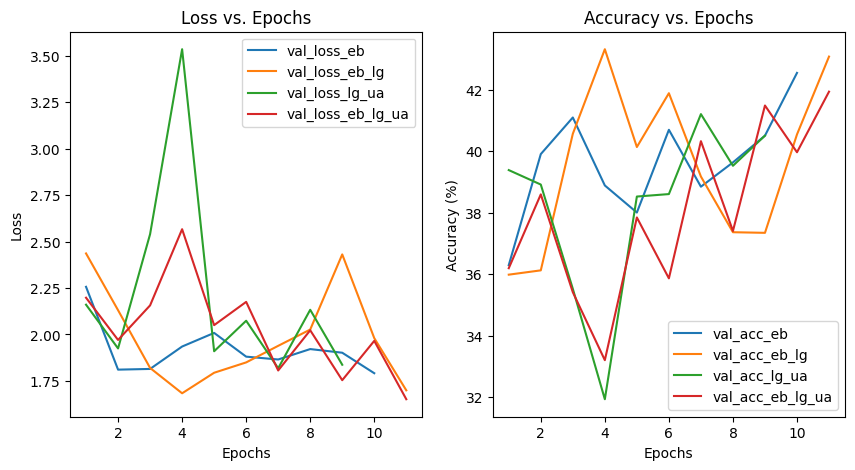

In [35]:
from matplotlib import pyplot as plt

# 繪製損失圖
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
#plt.plot(range(1, epoch_eb+2), trn_loss_eb, label='trn_loss_eb')
plt.plot(range(1, epoch_eb+2), val_loss_eb, label='val_loss_eb')

#plt.plot(range(1, epoch_lg+2), trn_loss_lg, label='trn_loss_lg')
#plt.plot(range(1, epoch_lg+2), val_loss_lg, label='val_loss_lg')

#plt.plot(range(1, epoch_eb_lg+2), trn_loss_eb_lg, label='trn_loss_eb_lg')
plt.plot(range(1, epoch_eb_lg+2), val_loss_eb_lg, label='val_loss_eb_lg')

#plt.plot(range(1, epoch_lg_ua+2), trn_loss_lg_ua, label='trn_loss_lg_ua')
plt.plot(range(1, epoch_lg_ua+2), val_loss_lg_ua, label='val_loss_lg_ua')

#plt.plot(range(1, epoch_eb_lg_ua+2), trn_loss_eb_lg_ua, label='trn_loss_eb_lg_ua')
plt.plot(range(1, epoch_eb_lg_ua+2), val_loss_eb_lg_ua, label='val_loss_eb_lg_ua')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 繪製準確率圖
#plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 2)
#plt.plot(range(1, epoch_eb+2), trn_acc_eb, label='trn_acc_eb')
plt.plot(range(1, epoch_eb+2), val_acc_eb, label='val_acc_eb')

#plt.plot(range(1, epoch_lg+2), trn_acc_lg, label='trn_acc_lg')
#plt.plot(range(1, epoch_lg+2), val_acc_lg, label='val_acc_lg')

#plt.plot(range(1, epoch_eb_lg+2), trn_acc_eb_lg, label='trn_acc_eb_lg')
plt.plot(range(1, epoch_eb_lg+2), val_acc_eb_lg, label='val_acc_eb_lg')

#plt.plot(range(1, epoch_lg_ua+2), trn_acc_lg_ua, label='trn_acc_lg_ua')
plt.plot(range(1, epoch_lg_ua+2), val_acc_lg_ua, label='val_acc_lg_ua')

#plt.plot(range(1, epoch_eb_lg_ua+2), trn_acc_eb_lg_ua, label='trn_acc_eb_lg_ua')
plt.plot(range(1, epoch_eb_lg_ua+2), val_acc_eb_lg_ua, label='val_acc_eb_lg_ua')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()